# Head Motion at Physiological Signal Peaks

## Find Joint Resp/EOG/EMG Peaks

In [1]:
# misc directory is at the same level as scan directory, 
# so we need to change the current working directory to the root directory
# ONLY RUN THIS CELL ONCE

import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
from scan.io.load import DatasetLoad # type: ignore
from scan.model.avg import EventFinder

# initialize dataset loader
loader = DatasetLoad(
    'vanderbilt'
)
# initialize dictionary to store joint peaks
subj_ses_peaks = {}
# iterate over subjects and sessions to find joint peaks
for subj, ses in loader.iter:
    data, _= loader.load_scan(
        subj, ses, 
        data='physio',
        physio_high_pass=True,
        norm='zscore'
    )
    # get average of emg and eog channels
    eog = [
        data['physio']['eog1_amp'],
        data['physio']['eog2_amp']
    ]
    eog_mean = np.mean(np.hstack(eog), axis=1)[:,np.newaxis]
    emg = [
        data['physio']['emg1_amp'],
        data['physio']['emg2_amp'],
        data['physio']['emg3_amp']
    ]
    emg_mean = np.mean(np.hstack(emg), axis=1)[:,np.newaxis]
    # find joint peaks of resp, eog, and emg amplitudes
    event_finder = EventFinder(
        height=1,
        distance=10,
        co_localization_tolerance=3,
    )
    events = event_finder.find_events(
        signals={
            'resp_amp': np.squeeze(data['physio']['resp_amp']), 
            'eog_mean': np.squeeze(eog_mean),
            'emg_mean': np.squeeze(emg_mean),
        }
    )
    joint_events = event_finder.get_joint_events(
        signal_names=['resp_amp', 'eog_mean', 'emg_mean'],
        events=events.events,
        tolerance=1
    )
    subj_ses_peaks[subj, ses] = joint_events



/Users/taylorbolt/opt/miniconda3/envs/scan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Average Head Motion around Peaks

Bootstrap sample 1 of 500
Bootstrap sample 101 of 500
Bootstrap sample 201 of 500
Bootstrap sample 301 of 500
Bootstrap sample 401 of 500


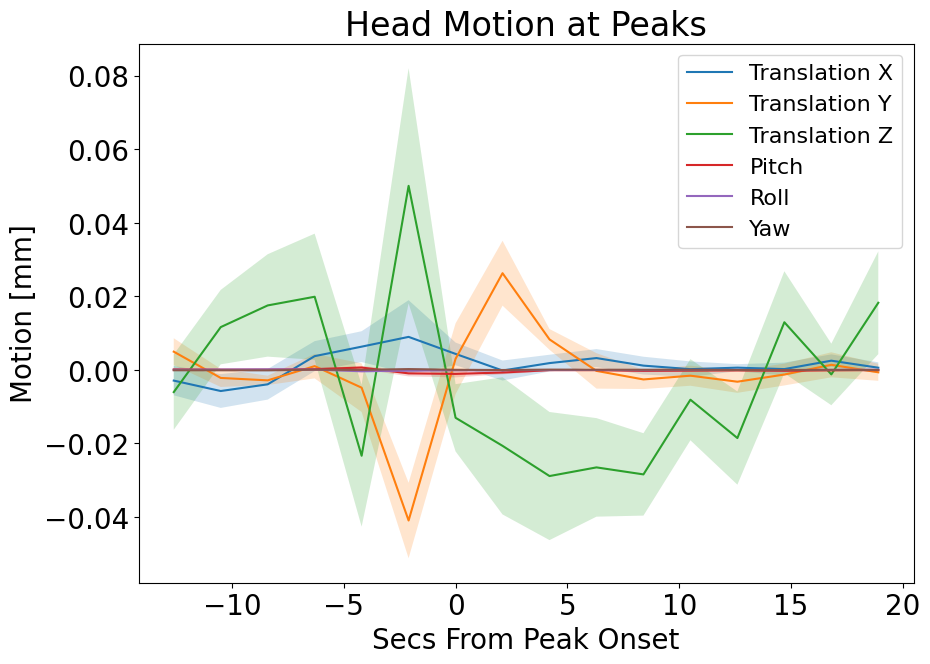

In [3]:
%matplotlib inline

import json

import matplotlib
import matplotlib.pyplot as plt

from scan.model.avg import extract_range # type: ignore
from scan.preprocess.pipeline import FileMapper
from scan.preprocess.fsl import load_fsl_motion_params
from scan.io.utils import filter

from main import _generate_bootstrap_samples


# set event duration of 'peak' in seconds
EVENT_DUR = 10

# shift left peaks by 5 seconds to capture pre-peak activity
SHIFT_LEFT = 5

# Specify upper and lower limits of frequency range
freqs = np.linspace(2,20,30)

# load parameters for vanderbilt dataset
with open('scan/meta/params.json', 'rb') as f:
    params = json.load(f)['vanderbilt']

# get file paths to .mat eeg data
file_mapper = FileMapper(
    dataset='vanderbilt',
    params=params
)
file_paths = file_mapper.map()

# get subject session list
subject_session_list = list(loader.iter)
# initialize dictionary to store motion data for each subject and session
subj_ses_motion = {
    'trans_x': {subj_ses: [] for subj_ses in subject_session_list},
    'trans_y': {subj_ses: [] for subj_ses in subject_session_list},
    'trans_z': {subj_ses: [] for subj_ses in subject_session_list},
    'pitch': {subj_ses: [] for subj_ses in subject_session_list},
    'roll': {subj_ses: [] for subj_ses in subject_session_list},
    'yaw': {subj_ses: [] for subj_ses in subject_session_list}
}
labels = {
    'trans_x': 'Translation X',
    'trans_y': 'Translation Y',
    'trans_z': 'Translation Z',
    'pitch': 'Pitch',
    'roll': 'Roll',
    'yaw': 'Yaw',
}

# iterate over subjects and sessions, load .mat eeg data
for subj, ses in loader.iter:
    # load .par motion file
    motion = load_fsl_motion_params(file_paths['physio'][subj][ses]['raw']['motion'])
    # filter motion data
    motion = {
        m: filter(motion[m], high_pass=True, low_pass=False, tr=2.1) 
        for m in motion
    }    
    # get joint peaks of resp, eog, and emg amplitudes
    peaks = subj_ses_peaks[subj, ses]
    # get first onset of joint peaks in seconds
    peaks = [p[0] for p in peaks]
    # extract motion data for each peak
    for m in motion:
        motion_data = motion[m][:, np.newaxis]
        motion_peaks = []
        # index windows for each marker
        for center in peaks:
            subj_ses_motion[m][subj, ses].append(
                extract_range(motion_data, center, -SHIFT_LEFT, EVENT_DUR)
            )

# generate 500 bootstrap samples
bootstrap_samples = _generate_bootstrap_samples(
    subject_session_list, 
    n_bootstrap=500
)

# loop through bootstrap sample and calculate average motion at peaks
bootstrap_motion = {
    'trans_x': [],
    'trans_y': [],
    'trans_z': [],
    'pitch': [],
    'roll': [],
    'yaw': []
}

for i, sample in enumerate(bootstrap_samples):
    if i % 100 == 0:
        print(f'Bootstrap sample {i+1} of {len(bootstrap_samples)}')
    # loop through motion labels and calculate average of motion at peaks
    for m in labels.keys():
        motion_data = [
             peak_data for subj, ses in sample
             for peak_data in subj_ses_motion[m][subj, ses]
        ]
        bootstrap_motion[m].append(np.nanmean(motion_data, axis=0))

# get mean and std of motion at peaks
bootstrap_motion_mean = {
    m: np.squeeze(np.nanmean(bootstrap_motion[m], axis=0)) 
    for m in labels.keys()
}
bootstrap_motion_std = {
    m: np.squeeze(np.nanstd(bootstrap_motion[m], axis=0)) 
    for m in labels.keys()
}
# create figure
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Head Motion at Peaks', fontsize=24)
ax.set_xlabel('Secs From Peak Onset', fontsize=20)
ax.set_ylabel('Motion [mm]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
time = np.arange(-SHIFT_LEFT-1, EVENT_DUR)*2.1
for m in labels.keys():
    ax.plot(time, bootstrap_motion_mean[m], label=labels[m])
    ax.fill_between(
        time, 
        bootstrap_motion_mean[m] - bootstrap_motion_std[m], 
        bootstrap_motion_mean[m] + bootstrap_motion_std[m], 
        alpha=0.2
    )
ax.legend(fontsize=16)

plt.show()




